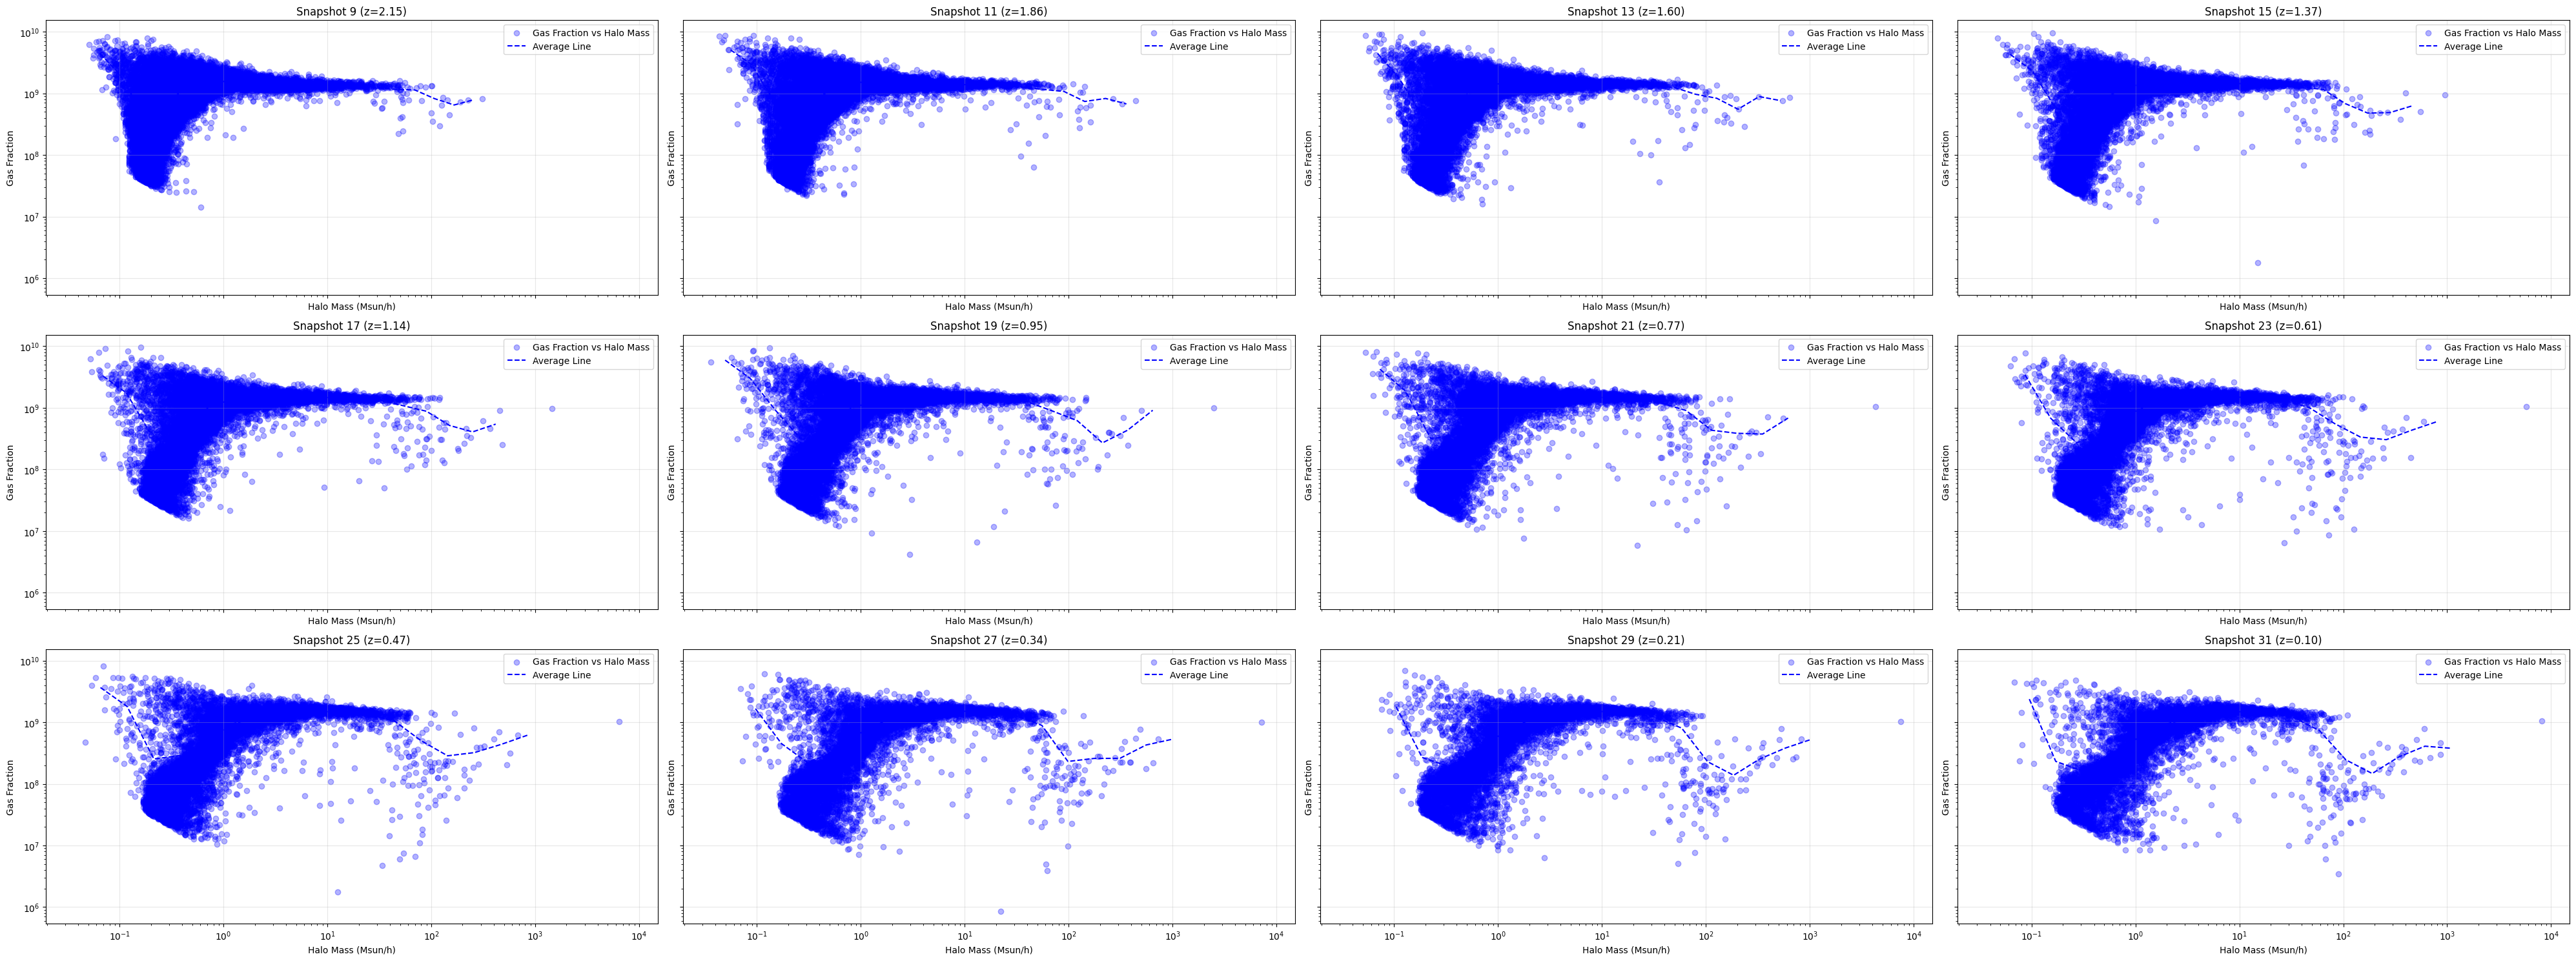

In [38]:
import h5py
import numpy as np
import matplotlib.pyplot as plt

def bin_data_with_mask(x, y, num_bins=20):
    # Generate logarithmic bins for better scaling
    bins = np.geomspace(np.min(x), np.max(x), num_bins + 1)
    bin_indices = np.digitize(x, bins) - 1
    bin_averages = [
        np.mean(y[bin_indices == i]) if np.any(bin_indices == i) else np.nan
        for i in range(num_bins)
    ]
    bin_centers = (bins[:-1] + bins[1:]) / 2
    return bin_centers, np.array(bin_averages), x, y

def snapshot_graph_gas_fraction_vs_halo_mass(): 
    num_snapshots = 12
    num_cols = 4
    num_rows = 3  
    
    fig, axs = plt.subplots(num_rows, num_cols, figsize=(10 * num_cols, 5 * num_rows), sharex=True, sharey=True)  
    
    plot_count = 0
    skipped_groups = 0
    total_groups = 0
    
    for i in range(9, 33, 2):
        gas_fractions = []
        halo_masses = []
        
        result = f"{i:03d}"
        file_path = f"./SimbaTNG-production/bondi_dbug_corrected/snap_{result}.hdf5"
        f_catalog = f"./SimbaTNG-production/bondi_dbug_corrected/fof_subhalo_tab_{result}.hdf5"

        try:
            with h5py.File(file_path, "r") as data, h5py.File(f_catalog, 'r') as f:
                redshift = data["Header"].attrs["Redshift"]
                
                subhalo_group_nr = f['Subhalo/SubhaloGroupNr'][:]
                subhalo_gas_mass = f["Subhalo/SubhaloMassType"][:, 0] * 1e10  # Gas mass (Msun/h)
                subhalo_total_mass = f["Subhalo/SubhaloMassType"][:, 0] + f["Subhalo/SubhaloMassType"][:, 1] + f["Subhalo/SubhaloMassType"][:, 4]  # Total mass (Gas + Stars + BH)
                
                for subgroup_idx in range(len(subhalo_group_nr)):
                    gas_fractions.append(subhalo_gas_mass[subgroup_idx] / subhalo_total_mass[subgroup_idx])
                    halo_masses.append(subhalo_total_mass[subgroup_idx])
                
        except FileNotFoundError:
            print(f"Snapshot file {file_path} or catalog {f_catalog} not found. Skipping...")
            continue
        
        # Convert to numpy arrays
        gas_fractions = np.array(gas_fractions)
        halo_masses = np.array(halo_masses)

        # Remove zeros
        valid_indices = np.where((gas_fractions != 0) & (halo_masses != 0))[0]
        gas_fractions = gas_fractions[valid_indices]
        halo_masses = halo_masses[valid_indices]

        # Bin data and calculate means
        binned_x, bin_averages, rawX, rawY = bin_data_with_mask(halo_masses, gas_fractions)
        
        # Plotting
        ax = axs[plot_count // num_cols, plot_count % num_cols]
        ax.scatter(rawX, rawY, color="blue", alpha=0.3, label="Gas Fraction vs Halo Mass")
        ax.plot(binned_x, bin_averages, color="blue", linestyle="--", label="Average Line")

        ax.set_xscale("log")
        ax.set_yscale("log")
        ax.set_xlabel("Halo Mass (Msun/h)")
        ax.set_ylabel("Gas Fraction")
        ax.set_title(f"Snapshot {i} (z={redshift:.2f})")
        ax.grid(alpha=0.3)
        ax.legend()

        plot_count += 1

    plt.tight_layout()
    plt.show()

snapshot_graph_gas_fraction_vs_halo_mass()